In [1]:
%load_ext autoreload
%autoreload 2

import torch
from spaces import NSphereSpace
from visualization_utils.spheres import visualize_spheres_side_by_side

from encoders import get_mlp

import matplotlib.pyplot as plt

from simclr.simclr import SimCLR

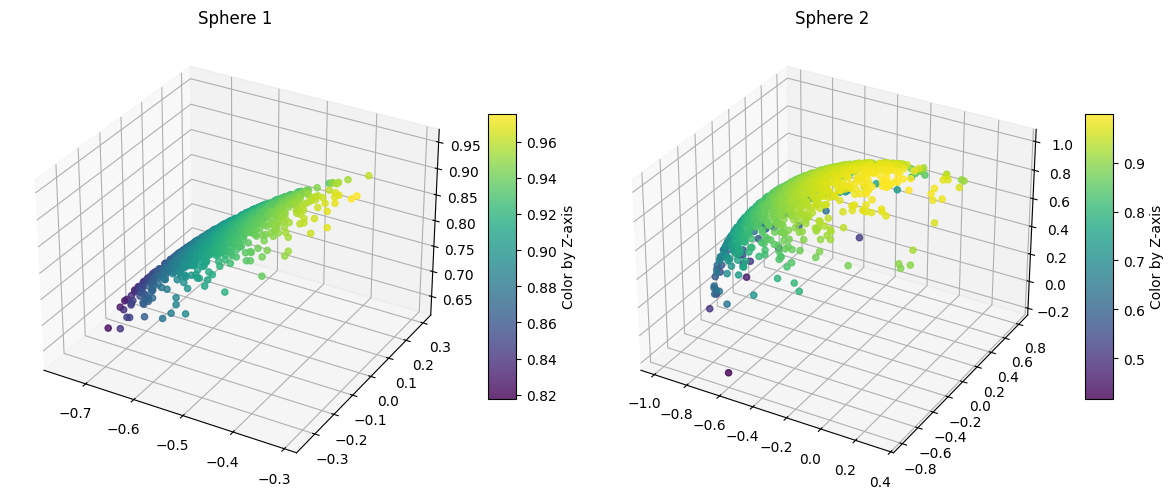

In [56]:
latent_dimension = 3 # Operate on a latent space dimension 3
data_dimension = 3 # Make data dimension identical
kappa = tau = 10
normal_concentration_param = 0.1 # Default in Zimmerman's code

iterations = 1000
batch = 6144

# Initialize a unit hypersphere of dimension 3
sphere = NSphereSpace(latent_dimension)
ref = sphere.uniform(1)[0]
z1 = sphere.von_mises_fisher(ref, 0.1, 1000)

# Take a lot of samples for training

z2 = sphere.von_mises_fisher(ref, 10, 1000)
z_aug = sphere.normal(ref, normal_concentration_param, 1000)

visualize_spheres_side_by_side(plt, z_aug, z2)

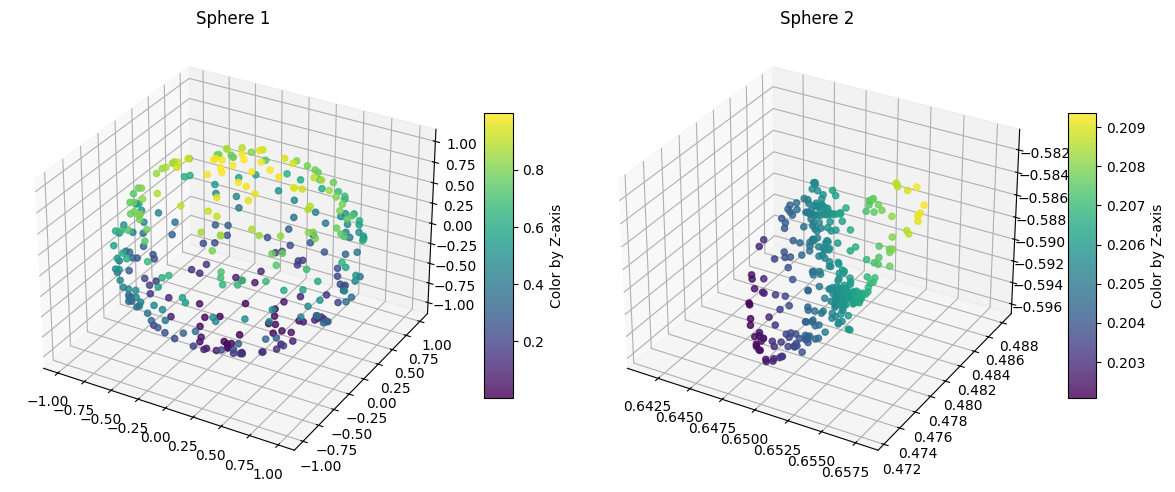

In [52]:
# Initialize data generation process
g = torch.nn.Identity()

# Initialize the multi-layer perceptron used for encoding
f = get_mlp(
    n_in=data_dimension,
    n_out=latent_dimension,
    layers=[
        3 * 10,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 10,
    ],
    output_normalization="fixed_sphere",
).to("cpu")

h = lambda z: f(g(z))

z = sphere.uniform(300)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z, z_enc)

Loss: 8.723388671875 Samples processed: 1
Loss: 8.638768196105957 Samples processed: 251
Loss: 8.635115623474121 Samples processed: 501
Loss: 8.635043144226074 Samples processed: 751


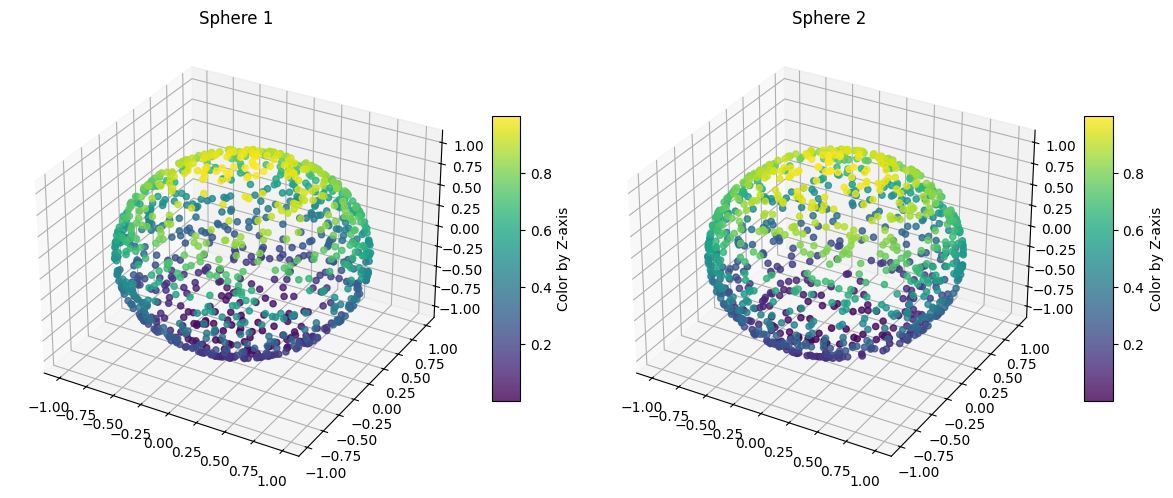

In [53]:
# Perform training

sample_pair_fixed = lambda batch: sphere.sample_pair_vmf(batch, kappa)
sample_uniform_fixed = lambda batch: sphere.uniform(batch)

simclr_vmf = SimCLR(
    f, g, sample_pair_fixed, sample_uniform_fixed, tau
)

f = simclr_vmf.train(batch, iterations)
h = lambda z: f(g(z))

z = sphere.uniform(1000)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z, z_enc)

Loss: 8.723384857177734 Samples processed: 1
Loss: 8.62692642211914 Samples processed: 251
Loss: 8.625657081604004 Samples processed: 501
Loss: 8.625622749328613 Samples processed: 751
Loss: 8.62561321258545 Samples processed: 1001
Loss: 8.625617980957031 Samples processed: 1251
Loss: 8.625615119934082 Samples processed: 1501
Loss: 8.625590324401855 Samples processed: 1751


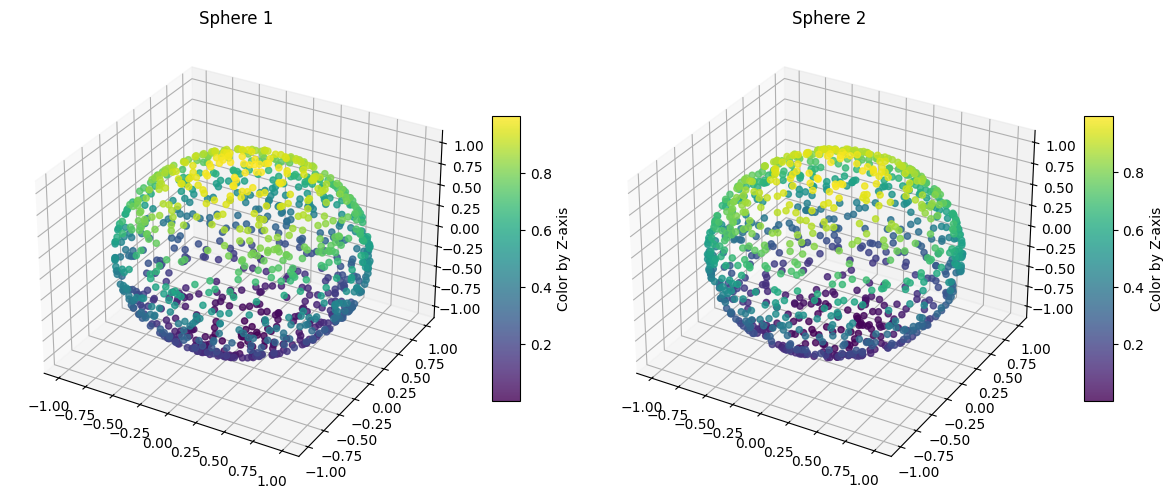

In [55]:
normal_concentration_param = 0.05

sample_pair_fixed = lambda batch: sphere.sample_pair_normal(batch, normal_concentration_param)
sample_uniform_fixed = lambda batch: sphere.uniform(batch)

f_normal = get_mlp(
    n_in=data_dimension,
    n_out=latent_dimension,
    layers=[
        3 * 10,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 10,
    ],
    output_normalization="fixed_sphere",
).to("cpu")

simclr_normal = SimCLR(
    f_normal, g, sample_pair_fixed, sample_uniform_fixed, tau
)

f_normal = simclr_normal.train(batch, 2000)
h = lambda z: f(g(z))

z = sphere.uniform(1000)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z, z_enc)